# Tutorial - ``params``, ``options``, and simulation

In this first tutorial we will learn how to specify and simulate a simple model with ``respy``. As economists love Robinsonades [<sup>1</sup>](#fn1), we will implement a simple Robinson Crusoe economy as a discrete choice dynamic programming model. 

In [1]:
%matplotlib inline

import pandas as pd
import respy as rp
import matplotlib.pyplot as plt
import seaborn as sns

## The model: a simple Robinson Crusoe economy

In this basic Robinson Crusoe economy, Robinson is alone on a desert island and must choose every period $t = \{0, 1, ... T-1\}$ between two alternatives: fishing or relaxing on his hammock. Each of the two alternatives is associated with a certain level of instantaneous utility, determined in each period $t$ by a deterministic component and a stochastic component. As Robinson cannot foresee these stochastic components, we speak of "choice under uncertainty".<br>

In ``respy``, the instantaneous utility of an alternative, $u_t$, consists of the sum of a pecuniary reward or wage $W_t$ and a non-pecuniary reward $N_t$.<br> 
Speaking of a wage in this context seems inappropriate since Robinson, being alone on an island, won't receive any wage for the time he spends fishing. However, this distinction is useful to keep in mind when tackling more complex models of labor supply.

The **wage** is zero if Robinson chooses to relax on his hammock. If Robinson goes fishing his wage at time $t$ is:

$$
W^f = exp\{x_t \beta^f + \epsilon_{ft}\}
$$

where:

- $f$ indicates the "fishing" alternative; 
- $x_t$ denotes Robinson's experience in fishing in period $t$;
- $\beta^f$ denotes the return to experience in fishing; 
- $\epsilon_{ft}$ is the random shock in period $t$.<br>

In words, the deterministic component of Robinson's wage is generated each day by only one covariate, his current experience in fishing (which is 0 if Robinson never fished before, 1 if Robinson fished once before, and so on), times the return to experience in fishing. The stochastic component, $\epsilon_{ft}$, is drawn from a normal distribution, and (may) depend on the current time $t$ and on Robinson's current choice. 

The **non-pecuniary reward** for fishing and relaxing on the hammock are simply set as constant terms, with an additional shock, also drawn from a Normal distribution, entering the latter additively: 

$$\begin{align}
N^f = \alpha^f \\
N^h = \alpha^h + \epsilon_{ht}\
\end{align}$$

Therefore, the parameters of this simple model are $\alpha^h$ and $\alpha^f$ (the constants in the non-pecuniary rewards) and $\beta^f$ (return to experience in fishing), along with the time-preference parameter (see below) and the lower triangular elements of the variance-covariance matrix which governs the distribution of the shocks. 

More generally, ``respy`` allows the wage and non-pecuniary rewards to be flexibly generated specifying a vector of choice- and time-dependent covariates and the associated vector of choice-dependent parameters. 

## Solution

Discrete choice models are usually derived under an assumption of utility-maximizing behavior by the decision-maker. Indeed, below we assume that Robinson is forward-looking and thus, in each period $t$, wants to maximize the expected present value of utility over the remaining periods. However, Robinson can discount the utility stream derived from future periods in different ways. ``respy`` allows for:

- Exponential discounting
- Hyperbolic discounting (with a completely naïve agent)

In the following, we assume Robinson to be an exponential discounter. This means that Robinson's time preferences can be described by:

$$
U_t(u_t, u_{t+1}, ...) \equiv \sum_{t=0}^T{\delta^t u_t}
$$

where $\delta \in (0, 1]$  is the long-run discount factor which capture Robinson's preferences for immediate
over future gratification.

If $\delta=0$, Robinson is completely myopic and in each period $t$ simply chooses the alternative associated with the highest instantaneous utility. If $\delta>0$, in each period $t$, Robinson doesn't compare levels of instantaneous utility
but *value functions* which incorporate the utility derived from future choices.<br>
Robinson's problem (choosing the optimal sequence of alternatives) can be solved with dynamic programming: The resulting decision rule can be used to simulate the choices Robinson would make under a different set of parameters — that is, to simulate counterfactuals.

## Specification: ``params`` and ``options``

The parameters of this simple model can be easily loaded with ``respy``. The resulting DataFrame contains a two-level MultiIndex to group parameters (identified by a unique name and value) in categories. In particular:

- ``"delta"`` refers to Robinson's long-run discount factor;
- ``"wage_fishing"``groups the covariates and associated parameters appearing in the wage. Indeed, ``"exp_fishing"`` represents Robinson's experience in fishing (which is determined endogenously and recomputed from period to period) while the associated ``value`` is the return to experience;
- ``"nonpec_fishing"`` groups the covariates and associated parameters appearing in the non-pecuniary rewards, and therefore contains two constant terms. Note that in the example below we set ``"nonpec_fishing"`` to be negative, to reflect the effort cost of fishing, while ``"nonpec_hammock"`` is set as positive to reflect the good feeling of relaxing on the hammock.
- ``"shocks_sdcorr"`` groups the lower triangular elements of the shocks variance-covariance matrix. In ``respy``, shocks are allowed to be correlated across choices.

In [2]:
params, options = rp.get_example_model("robinson_crusoe_basic", with_data=False)

In [3]:
params

value
category       name                       
delta          delta                  0.95
wage_fishing   exp_fishing            0.30
nonpec_fishing constant              -0.20
nonpec_hammock constant               2.00
shocks_sdcorr  sd_fishing             0.50
               sd_hammock             0.50
               corr_hammock_fishing   0.00

``params`` is complemented with ``options``, which contain additional information needed for the solution, simulation and estimation of the model. For example, `"n_periods"` indicates the number of periods for which the model is solved and simulated, and ``"simulation_agents"`` indicates how many identical individuals are simulated. 

In [4]:
options

{'solution_draws': 100,
 'solution_seed': 456,
 'n_periods': 5,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'estimation_draws': 100,
 'estimation_seed': 100,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'covariates': {'constant': '1'}}

Note that the behavior across identical simulated individuals can differ, as each of them faces a different sequence of random shocks: Seeds (denoted by ``"_seed"``in the ``options``) are used in every model component to ensure reproducibility. You can use any seed you like or even repeat the same seed number. Internally, we ensure that randomness is completely uncorrelated.

## Simulation

We are now ready to simulate the model: We will simulate 1000 identical Robinsons and let the decision rule from the solution of the model guide them for 5 periods. Although the 1000 Robinsons start with the same characteristics, their actions from period to period can differ because of the different shocks they experience. 

We will then inspect the predicted shares of Robinsons who choose the "fishing" or "hammock" alternative respectively. In other words, we will inspect the predicted probability with which Robinson chooses between fishing and relaxing on his hammock in each period.

Performing a simulation returns a MultiIndex containing all the information needed to inspect Robinson's decisions period by period, including his choice, instantaneous utility and level of experience in each period. Each of the 1000 Robinsons chooses one alternative in each ``"Period"`` and has a personal ``"Identifier"``.

In [5]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

In [6]:
df.head(10)

Experience_Fishing  Shock_Reward_Fishing  \
Identifier Period                                             
0          0                        0             -0.035035   
           1                        0              0.074254   
           2                        0             -0.354560   
           3                        0             -0.109397   
           4                        0             -1.063705   
1          0                        0             -0.713137   
           1                        0             -0.464134   
           2                        0              0.066755   
           3                        0             -0.748565   
           4                        0             -0.130574   

                   Meas_Error_Wage_Fishing  Shock_Reward_Hammock  \
Identifier Period                                                  
0          0                             1              0.040965   
           1                             1              1.506491   
           2                             1              1.185316   
           3                             1             -0.785877   
           4                             1              1.245234   
1          0                             1              1.418950   
           1                             1             -0.384774   
           2                             1             -0.844060   
           3                             1             -1.348821   
           4                             1             -0.539693   

                   Meas_Error_Wage_Hammock  Dense_Key  Core_Index   Choice  \
Identifier Period                                                            
0          0                             1          0           0  hammock   
           1                             1          1           0  hammock   
           2                             1          2           0  hammock   
           3                             1          3           0  hammock   
           4                             1          4           0  hammock   
1          0                             1          0           0  hammock   
           1                             1          1           0  hammock   
           2                             1          2           0  hammock   
           3                             1          3           0  hammock   
           4                             1          4           0  hammock   

                   Wage  Discount_Rate  ...  Nonpecuniary_Reward_Fishing  \
Identifier Period                       ...                                
0          0        NaN           0.95  ...                         -0.2   
           1        NaN           0.95  ...                         -0.2   
           2        NaN           0.95  ...                         -0.2   
           3        NaN           0.95  ...                         -0.2   
           4        NaN           0.95  ...                         -0.2   
1          0        NaN           0.95  ...                         -0.2   
           1        NaN           0.95  ...                         -0.2   
           2        NaN           0.95  ...                         -0.2   
           3        NaN           0.95  ...                         -0.2   
           4        NaN           0.95  ...                         -0.2   

                   Wage_Fishing  Flow_Utility_Fishing  Value_Function_Fishing  \
Identifier Period                                                               
0          0           0.982635              0.782635                9.172605   
           1           1.037825              0.837825                6.911083   
           2           0.837545              0.637545                4.677616   
           3           0.946770              0.746770                2.793888   
           4           0.587516              0.387516                0.387516   
1          0           0.700

Stacked bar charts help visualize Robinson's choices. All the plots below can be easily generated with the ``Matplotlib`` library.

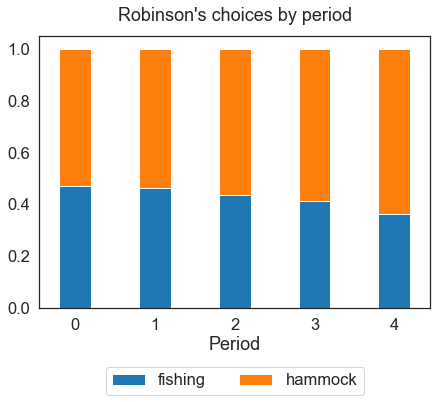

In [7]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(figsize=(7, 5))

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    width=0.4, stacked=True, ax=ax
)
plt.xticks(rotation="horizontal")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=2)
plt.title("Robinson's choices by period", pad=15)

plt.show()

A payoff of structural models is the possibility to simulate the same model in a counterfactual environment, to help answer "what if" questions that can be highly relevant for policy purposes. As an example, in models of educational choice, the analysis of comparative statics is often applied to evaluate the effect of alternative tuition policies on average educational attainment. 

We will now show how, in this simple Robinson Crusoe economy, changing one parameter affects Robinson's behavior: How do Robinson's choices change if we increase the return to experience in fishing? We can simulate the model again under a different set of parameters and inspect Robinson's new choices. 

In [8]:
return_exp = [0.2, 0.25, 0.3, 0.35]

In [9]:
list_df = []
for r in return_exp:
    params.loc[("wage_fishing", "exp_fishing"), "value"] = r
    simulate = rp.get_simulate_func(params, options)
    df = simulate(params)
    list_df.append(df)

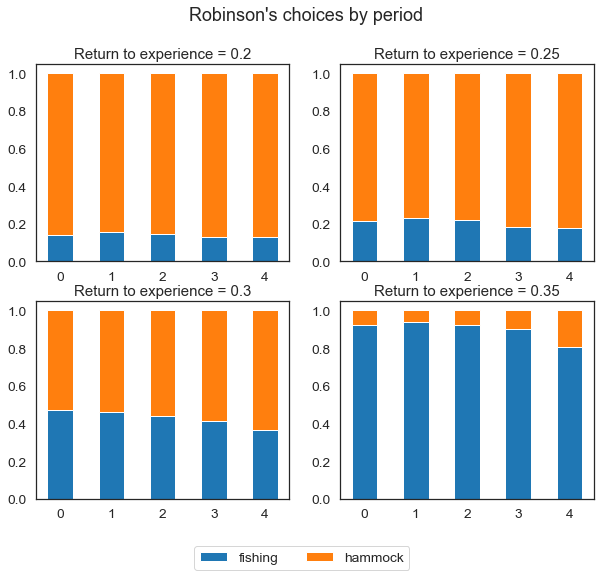

In [10]:
sns.set_context("notebook", font_scale=1.25)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

width = 0.5
axs = axs.flatten()

for ax, df, r in zip(axs, list_df, return_exp):
    hammock = (
        df.groupby("Period")
        .Choice.value_counts(normalize=True)
        .unstack()
        .loc[:, "hammock"]
    )
    fishing = (
        df.groupby("Period")
        .Choice.value_counts(normalize=True)
        .unstack()
        .loc[:, "fishing"]
    )

    ax.bar(fishing.index, fishing.values, width=width, label="fishing")
    ax.bar(hammock.index, hammock.values, width=width, bottom=fishing, label="hammock")

    ax.set_title("Return to experience = " + str(r))
    plt.xticks(rotation="horizontal")

plt.legend(loc="right", bbox_to_anchor=(0.3, -0.3), ncol=2)
plt.suptitle("Robinson's choices by period")

plt.show()

As ``"exp_fishing"`` increases, Robinson is more and more likely to fish in each period. For higher returns to experience, Robinson spends all of his time fishing, while for low values he spends all of his time on his hammock. Varying just one parameter results in very different predicted outcomes.

***

**Footnotes**

<span id="fn1"><sup>1</sup>
    One of the earliest references of Robinsonades in Economics can be found in Marx (1867). In the 37th footnote, he mentions that even Ricardo used the theme before him.
</span>

## References

Marx, K. (1867). Das Kapital, Bd. 1. *MEW*, Bd, 23, 405